In [5]:
import numpy as np
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
from plot_cluster_data import collect_data_for_all_clusters
from tqdm import tqdm
import xarray as xr

In [6]:
def collect_data_for_cluster(cluster_dir, dem_dir):
    """Collect temperature, humidity, pressure, and elevation data for all files in a cluster's directory."""
    temperature_values = []
    humidity_values = []
    pressure_values = []
    elevation_values = []
    
    # Loop through all NetCDF files in the cluster directory
    for file_name in tqdm(os.listdir(cluster_dir)):
        if file_name.endswith(".nz"):
            file_path = os.path.join(cluster_dir, file_name)
            
            # Open the NetCDF file and extract variables
            with xr.open_dataset(file_path) as ds:
                temperature = ds['T_2M'].values.mean()
                humidity = ds['RELHUM_2M'].values.mean()
                pressure = ds['PS'].values.mean()

                # Corresponding DEM file for elevation
                dem_file = f"{file_name.split('_')[0]}_{file_name.split('_')[1]}_dem.nc"
                dem_path = os.path.join(dem_dir, dem_file)

                # Read the DEM file to get elevation
                if os.path.exists(dem_path):
                    elevation_ds = xr.open_dataset(dem_path)
                    elevation = elevation_ds['HSURF'].values.mean()
                else:
                    elevation = None  # Skip if elevation data is missing

                if elevation is not None:
                    temperature_values.append(temperature)
                    humidity_values.append(humidity)
                    pressure_values.append(pressure)
                    elevation_values.append(elevation)

    return temperature_values, humidity_values, pressure_values, elevation_values


def lapse_rate_correction(T_2m, elevation, ref_elevation, lapse_rate=0.0065):
    """
    Apply lapse rate correction to 2m temperature.

    Parameters:
    - T_2m: float or numpy array, original 2m temperature (Kelvin)
    - elevation: float or numpy array, local surface elevation (meters)
    - ref_elevation: float, reference elevation (default = 0, sea level)
    - lapse_rate: float, environmental lapse rate (default = 0.0065 K/m)

    Returns:
    - T_star: float or numpy array, elevation-invariant temperature (Kelvin)
    """
    return T_2m + lapse_rate * (elevation - ref_elevation)


def compute_lapse_rate(rh):
    """Compute RH-dependent lapse rate (Gamma in K/km)."""
    gamma_d = 9.8  # Dry adiabatic lapse rate (K/km)
    gamma_m = 6.0  # Approximate moist adiabatic lapse rate (K/km)
    gamma_rh = gamma_d - (gamma_d - gamma_m) * (rh ** 2)  # RH-dependent lapse rate
    return gamma_rh


def compute_lapse_rate(rh, T):
    """Compute RH-dependent lapse rate (Gamma in K/km) using a more accurate formulation."""
    gamma_d = 9.8  # Dry adiabatic lapse rate (K/km)
    gamma_m = 6.0  # Approximate moist adiabatic lapse rate (K/km)
    
    # Saturation vapor pressure (Tetens formula)
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))  # in hPa
    e = rh * e_s  # Actual vapor pressure (hPa)
    
    # Mixing ratio (approximate)
    p = 1013.25  # Standard pressure at sea level in hPa
    w = 0.622 * (e / (p - e))
    
    # Adjust lapse rate based on moisture content
    gamma_rh = gamma_d - (gamma_d - gamma_m) * (w / (w + 0.622))
    return gamma_rh


def compute_lapse_rate_accurate(RH, T, P_surf):
    """Compute RH-dependent lapse rate (Gamma in K/km) using a more physically accurate formula."""
    gamma_d = 9.8  # Dry adiabatic lapse rate (K/km)
    
    # Constants
    L_v = 2.5e6  # Latent heat of vaporization (J/kg)
    cp = 1005  # Specific heat of dry air (J/kg/K)
    epsilon = 0.622  # Ratio of molecular weights of water vapor to dry air
    
    # Saturation vapor pressure (Tetens formula)
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))  # in hPa
    e = RH * e_s  # Actual vapor pressure (hPa)
    
    # Mixing ratio
    w = epsilon * (e / (P_surf - e))  # kg/kg
    
    # Virtual temperature correction
    Tv = (T + 273.15) * (1 + 0.61 * w)
    
    # Moist adiabatic lapse rate (Deduced from Clausius-Clapeyron)
    gamma_m = gamma_d * (1 + (L_v * w) / (cp * Tv)) / (1 + (L_v**2 * w) / (cp * 287 * Tv**2))
    
    return gamma_m


def adjust_temperature_to_sea_level(T, RH, P_surf, z_ref, z):
    """Compute sea-level adjusted temperature."""
    gamma_rh = compute_lapse_rate_accurate(RH, T, P_surf)
    T_sea_level = T + gamma_rh * ((z - z_ref) / 1000)  # Convert z to km
    return T_sea_level, gamma_rh


def compute_potential_temperature(T, P_surf, P_ref=1000):
    """Compute potential temperature (Theta) given surface pressure and 2m temperature.
    P_surf: Surface pressure in hPa
    P_ref: Reference pressure (default: 1000 hPa)
    """
    kappa = 0.286  # Poisson constant for dry air (R/cp)
    Theta = T * (P_ref / P_surf) ** kappa
    return Theta


def compute_equivalent_potential_temperature(T, P_surf, RH):
    """Compute equivalent potential temperature (Theta_e), accounting for latent heat release."""
    T_K = T + 273.15  # Convert to Kelvin
    L_v = 2.5e6  # Latent heat of vaporization (J/kg)
    cp = 1005  # Specific heat of dry air at constant pressure (J/kg/K)
    epsilon = 0.622  # Ratio of molecular weights of water vapor and dry air
    
    # Compute saturation vapor pressure (Tetens formula)
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))  # in hPa
    e = RH * e_s  # Actual vapor pressure (hPa)
    w = epsilon * (e / (P_surf - e))  # Mixing ratio (kg/kg)
    
    # Compute Theta_e using Bolton's approximation
    Theta_e = T_K * (1000 / P_surf) ** 0.286 * np.exp((L_v * w) / (cp * T_K))
    return Theta_e


def normalize_temperature(T_values, T_ref_values):
    """Normalize temperature distribution to match reference dataset statistics."""

    mu_T, sigma_T = np.mean(T_values), np.std(T_values)
    mu_ref, sigma_ref = np.mean(T_ref_values), np.std(T_ref_values)
    
    normalized_T = ((T_values - mu_T) / sigma_T) * sigma_ref + mu_ref
    
    return normalized_T

In [7]:
# data_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data"
data_path = "/Users/fquareng/data/"
dem_path = "dem_squares"
target_path = "8h-PS-RELHUM_2M-T_2M_cropped_gridded_clustered_threshold"
source_path = "8h-PS-RELHUM_2M-T_2M_cropped_gridded_clustered_threshold_blurred"
figures_directory = f"/Users/fquareng/phd/AdaptationSandbox/figures/feature_transformation"

In [8]:
temperature_7, humidity_7, pressure_7, elevation_7 = collect_data_for_cluster(os.path.join(data_path, source_path, "cluster_7"), os.path.join(data_path, dem_path))

100%|██████████| 22980/22980 [04:59<00:00, 76.81it/s] 


In [9]:
# temperature_1, humidity_1, pressure_1, elevation_1 = collect_data_for_cluster(os.path.join(data_path, source_path, "cluster_1"), os.path.join(data_path, dem_path))

In [10]:
temperature_0, humidity_0, pressure_0, elevation_0 = collect_data_for_cluster(os.path.join(data_path, source_path, "cluster_0"), os.path.join(data_path, dem_path))

100%|██████████| 36628/36628 [07:14<00:00, 84.35it/s] 


In [115]:
T_2m_7 = np.array(temperature_7).flatten()
T_2m_0 = np.array(temperature_0).flatten()

elev_7 = np.array(elevation_7).flatten()
elev_0 = np.array(elevation_0).flatten()

RH_7 = np.array(humidity_7).flatten()
RH_0 = np.array(humidity_0).flatten()

PS_7 = np.array(pressure_7).flatten()
PS_0 = np.array(pressure_0).flatten()

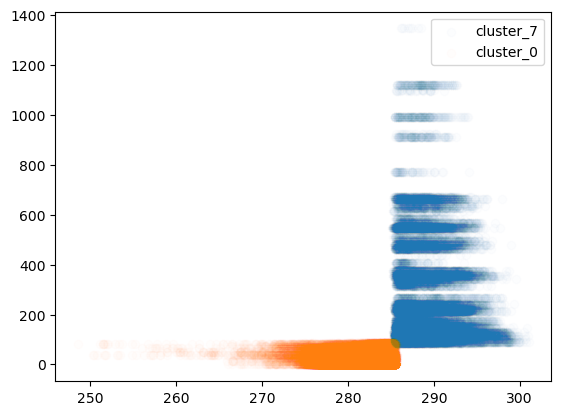

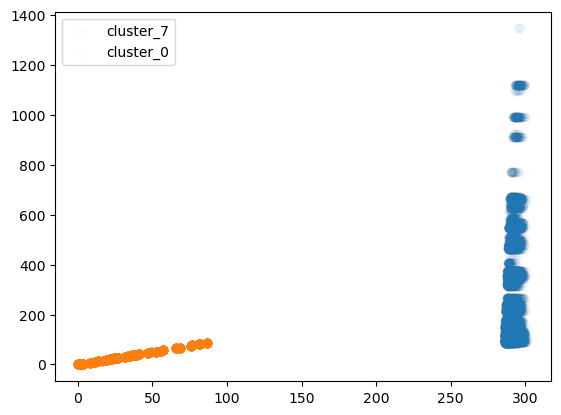

In [116]:
# First correction 
corrected_T_2m_7 = []
corrected_T_2m_0 = []
for T, e in zip(T_2m_7, elev_7):
    corrected_T_2m_7.append(lapse_rate_correction(T, e, ref_elevation=0, lapse_rate=0.0065))
for T, e in zip(elev_0, elev_0):
    corrected_T_2m_0.append(lapse_rate_correction(T, e, ref_elevation=0, lapse_rate=0.0065))

fig = plt.figure()
plt.scatter([x for x in T_2m_7], [y for y in elev_7], alpha=.01, label="cluster_7")
plt.scatter([x for x in T_2m_0], [y for y in elev_0], alpha=.01, label="cluster_0")
plt.legend()
plt.show()

fig = plt.figure()
plt.scatter([x for x in corrected_T_2m_7], [y for y in elev_7], alpha=.01, label="cluster_7")
plt.scatter([x for x in corrected_T_2m_0], [y for y in elev_0], alpha=.01, label="cluster_0")
plt.legend()
plt.show()

In [2]:
# Compute and display adjusted temperatures and potential temperatures
T_adj_0 = []
Theta_0 = []
Theta_0_e = []
gamma_0 = []
gamma_7 = []

for T, RH, z, PS in zip(T_2m_0, RH_0, elev_0, PS_0):
    gamma_0.append(adjust_temperature_to_sea_level(T, RH, PS, z_ref=0, z=z)[1])
    T_adj_0.append(adjust_temperature_to_sea_level(T, RH, PS, z_ref=0, z=z)[0])
    Theta_0.append(compute_potential_temperature(T, PS))
    Theta_0_e.append(compute_equivalent_potential_temperature(T, PS, RH))
T_adj_7 = []
Theta_7 = []
Theta_7_e = []
for T, RH, z, PS in zip(T_2m_7, RH_7, elev_7, PS_7):
    gamma_7.append(adjust_temperature_to_sea_level(T, RH, PS, z_ref=0, z=z)[1])
    T_adj_7.append(adjust_temperature_to_sea_level(T, RH, PS, z_ref=0, z=z)[0])
    Theta_7.append(compute_potential_temperature(T, PS))
    Theta_7_e.append(compute_equivalent_potential_temperature(T, PS, RH))


fig = plt.figure()
plt.scatter([x for x in T_2m_7], [y for y in elev_7], alpha=.01, label="cluster_7")
plt.scatter([x for x in T_2m_0], [y for y in elev_0], alpha=.01, label="cluster_0")
plt.legend()
plt.show()

fig = plt.figure()
plt.scatter([x for x in T_adj_7], [y for y in elev_7], alpha=.01, label="cluster_7")
plt.scatter([x for x in T_adj_0], [y for y in elev_0], alpha=.01, label="cluster_0")
plt.legend()
plt.show()

fig = plt.figure()
plt.scatter([x for x in Theta_7_e], [y for y in elev_7], alpha=.1, label="cluster_7")
plt.scatter([x for x in Theta_0_e], [y for y in elev_0], alpha=.1, label="cluster_0")
plt.legend()
plt.show()

fig = plt.figure()
plt.hist(Theta_7_e, alpha=.1)
plt.hist(Theta_0_e, alpha=.1)
plt.show()

fig = plt.figure()
plt.hist(T_2m_7, alpha=.1)
plt.hist(T_2m_0, alpha=.1)
plt.show()

NameError: name 'T_2m_0' is not defined

In [1]:
import numpy as np
from scipy.optimize import newton

def compute_temperature_from_theta_e(theta_e, RH, P_surf):
    """Compute temperature T from equivalent potential temperature θ_e using an optimized approach.
    
    - Supports **vectorized operations** for efficiency.
    - Uses **Newton’s method** for faster convergence.
    """
    L_v = 2.5e6  # Latent heat of vaporization (J/kg)
    cp = 1005    # Specific heat of dry air (J/kg/K)
    epsilon = 0.622  # Ratio of molecular weights of water vapor to dry air
    P_ref = 1000  # Reference pressure in hPa
    kappa = 0.286  # Poisson constant (R_d / c_p)

    # Compute saturation vapor pressure using Tetens' formula (vectorized)
    def saturation_vapor_pressure(T):
        return 6.112 * np.exp((17.67 * T) / (T + 243.5))

    # Compute actual vapor pressure (vectorized)
    def actual_vapor_pressure(T):
        return RH * saturation_vapor_pressure(T)

    # Compute mixing ratio (vectorized)
    def mixing_ratio(T):
        e = actual_vapor_pressure(T)
        return epsilon * (e / (P_surf - e))

    # Define the function to solve for T
    def equation(T):
        theta = T * (P_ref / P_surf) ** kappa
        w = mixing_ratio(T)
        return theta_e - theta * np.exp((L_v * w) / (cp * T))

    # Compute initial guess: assume θ_e is close to T (better than θ_e itself)
    T_initial = theta_e / ((P_ref / P_surf) ** kappa)

    # Solve using Newton’s method (faster than fsolve)
    T_solution = newton(equation, T_initial, maxiter=50, tol=1e-6)

    return T_solution

T_0 = compute_temperature_from_theta_e(Theta_0_e, RH_0, PS_0)
T_7 = compute_temperature_from_theta_e(Theta_7_e, RH_7, PS_7)

fig = plt.figure()
plt.hist(Theta_7_e, alpha=.1)
plt.hist(Theta_0_e, alpha=.1)
plt.show()

fig = plt.figure()
plt.hist(T_7, alpha=.1)
plt.hist(T_0, alpha=.1)
plt.show()

NameError: name 'Theta_0_e' is not defined

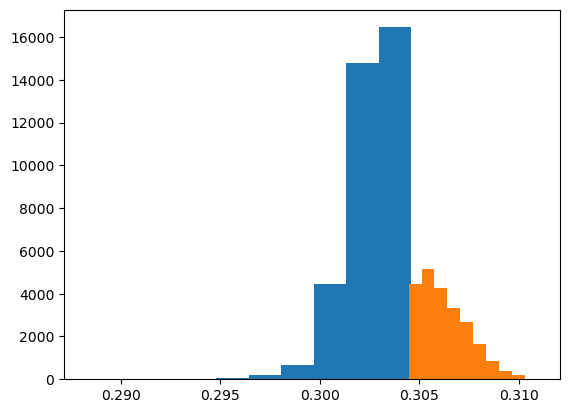

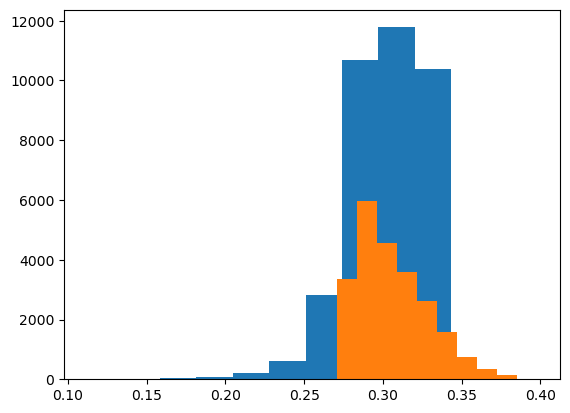

In [237]:
def compute_equivalent_potential_temperature(T, RH, P_surf):
    """Compute equivalent potential temperature θ_e (K)."""
    L_v = 2.5e6  # Latent heat of vaporization (J/kg)
    cp = 1005    # Specific heat of dry air (J/kg/K)
    epsilon = 0.622  # Ratio of molecular weights of water vapor to dry air
    
    # Compute saturation vapor pressure (hPa) using Tetens' formula
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))
    e = RH * e_s  # Actual vapor pressure (hPa)
    
    # Mixing ratio (kg/kg)
    w = epsilon * (e / (P_surf - e))
    
    # Compute potential temperature θ
    theta = T * (1000 / P_surf) ** 0.286
    
    # Compute equivalent potential temperature θ_e
    theta_e = theta * np.exp((L_v * w) / (cp * T))
    
    return theta_e


def normalize_lapse_rate(gamma_m, T, RH, P_surf):
    """Normalize lapse rate using equivalent potential temperature."""
    theta_e = compute_equivalent_potential_temperature(T, RH, P_surf)
    
    # Scale gamma_m by the deviation from the reference θ_e
    gamma_m_norm = gamma_m * (theta_e / np.mean(theta_e))
    
    return gamma_m_norm


def adjust_temperature_to_sea_level_gamma(T, RH, P_surf, z_ref, z):
    """Compute sea-level adjusted temperature."""
    gamma_rh = compute_lapse_rate_accurate(RH, T, P_surf)
    gamma_rh_adj = normalize_lapse_rate(gamma_rh, T, RH, P_surf)
    T_sea_level = T + gamma_rh_adj * ((z - z_ref) / 1000)  # Convert z to km
    return T_sea_level

plt.hist(gamma_0)
plt.hist(gamma_7)
plt.show()

plt.hist(normalize_lapse_rate(gamma_0, T_2m_0, RH_0, PS_0))
plt.hist(normalize_lapse_rate(gamma_7, T_2m_7, RH_7, PS_7))
plt.show()


In [229]:
def adjust_temperature_to_sea_level_gamma(T, RH, P_surf, z_ref, z):
    """Compute sea-level adjusted temperature."""
    gamma_rh = compute_lapse_rate_accurate(RH, T, P_surf)
    gamma_rh_adj = normalize_lapse_rate(gamma_rh, T, RH, P_surf)
    T_sea_level = T + gamma_rh_adj * ((z - z_ref) / 1000)  # Convert z to km
    return T_sea_level


def correct_temperature_for_lapse_and_moisture(T_sea_level, RH, P_surf, T_ref):
    """Correct temperature for lapse rate and moisture content using equivalent potential temperature."""
    # Compute equivalent potential temperature for the adjusted dataset
    theta_e = compute_equivalent_potential_temperature(T_sea_level, RH, P_surf)
    theta_ref = compute_equivalent_potential_temperature(T_ref, RH, P_surf)
    
    # Calculate the correction factor based on theta_e
    correction_factor = theta_e / theta_ref
    
    # Apply the correction to the sea-level adjusted temperature
    T_corrected = T_sea_level * correction_factor
    return T_corrected


In [230]:
T_ref = np.mean([np.mean(T_2m_0), np.mean(T_2m_7)])


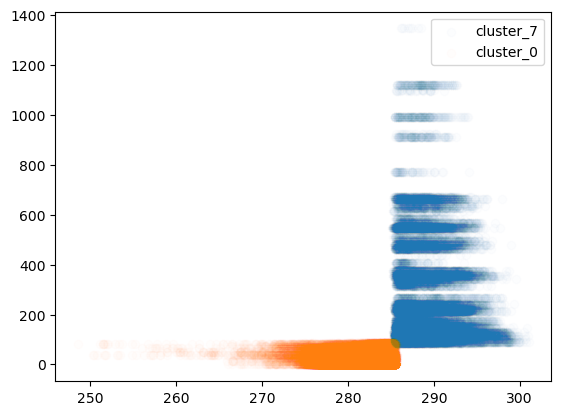

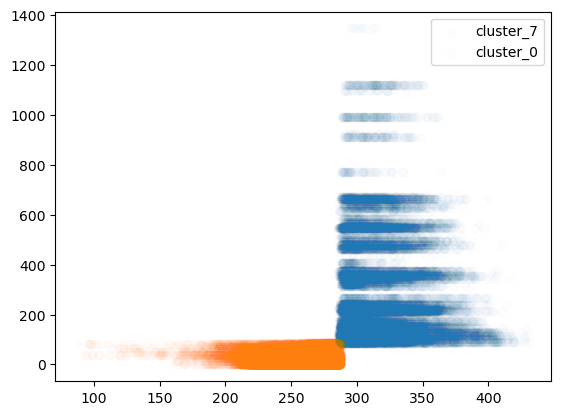

In [231]:

# Compute and display adjusted temperatures and potential temperatures
T_adj_0 = []
for T, RH, z, PS in zip(T_2m_0, RH_0, elev_0, PS_0):
    T_sea_level_0 = adjust_temperature_to_sea_level_gamma(T, RH, PS, z_ref=0, z=z)
    T_adj_0.append(correct_temperature_for_lapse_and_moisture(T_sea_level_0, RH, PS, T_ref))
T_adj_7 = []
for T, RH, z, PS in zip(T_2m_7, RH_7, elev_7, PS_7):
    T_sea_level_7 = adjust_temperature_to_sea_level_gamma(T, RH, PS, z_ref=0, z=z)
    T_adj_7.append(correct_temperature_for_lapse_and_moisture(T_sea_level_7, RH, PS, T_ref))
    
fig = plt.figure()
plt.scatter([x for x in T_2m_7], [y for y in elev_7], alpha=.01, label="cluster_7")
plt.scatter([x for x in T_2m_0], [y for y in elev_0], alpha=.01, label="cluster_0")
plt.legend()
plt.show()

fig = plt.figure()
plt.scatter([x for x in T_adj_7], [y for y in elev_7], alpha=.01, label="cluster_7")
plt.scatter([x for x in T_adj_0], [y for y in elev_0], alpha=.01, label="cluster_0")
plt.legend()
plt.show()


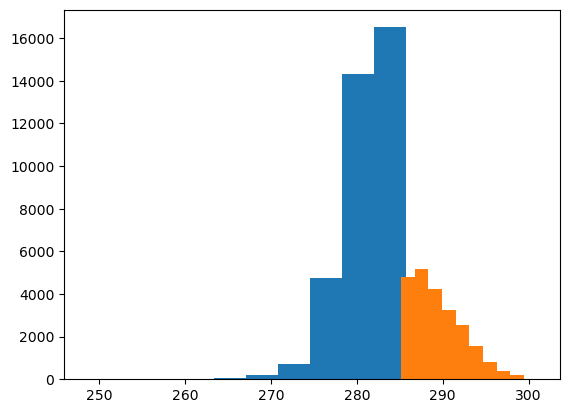

(array([5665., 5536., 4161., 3170., 2151., 1230.,  603.,  320.,  125.,
          19.]),
 array([284.88201904, 299.46557617, 314.04916382, 328.63272095,
        343.21630859, 357.79986572, 372.38342285, 386.9670105 ,
        401.55056763, 416.13415527, 430.7177124 ]),
 <BarContainer object of 10 artists>)

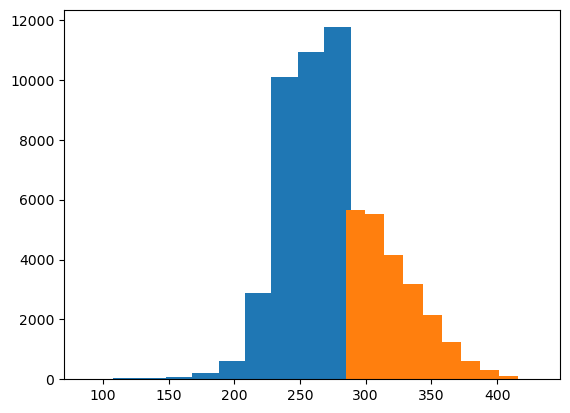

In [232]:
plt.hist(T_2m_0)
plt.hist(T_2m_7)
plt.show()

plt.hist(T_adj_0)
plt.hist(T_adj_7)

/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_98418/837508428.py:40: RuntimeWarning: divide by zero encountered in divide
  theta = T * (1000 / P_surf) ** 0.286
/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_98418/837508428.py:53: RuntimeWarning: invalid value encountered in divide
  gamma_m_norm = gamma_m * (theta_e / np.mean(theta_e))
/var/folders/90/16dx4cp1401_7sdk6m5tcspc0000gn/T/ipykernel_98418/837508428.py:76: RuntimeWarning: divide by zero encountered in divide
  z_eq = z + ((T - T_corrected) / gamma_norm) * 1000


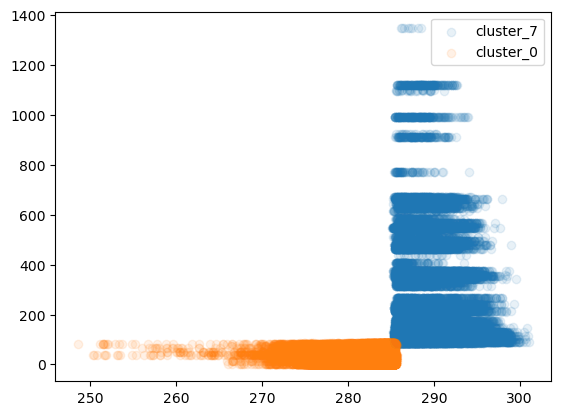

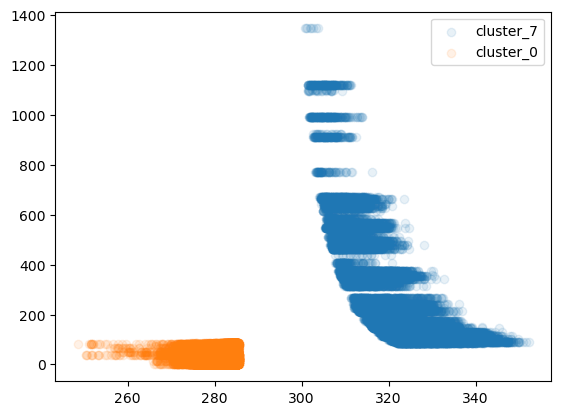

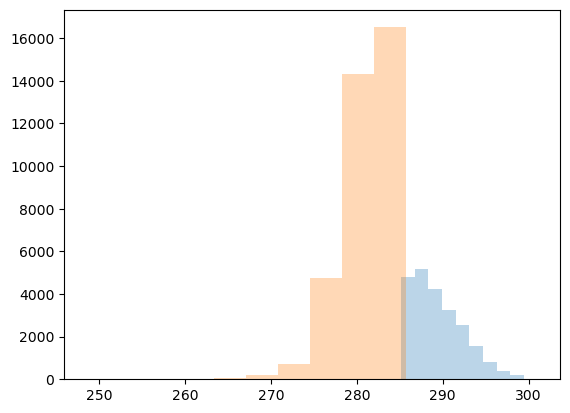

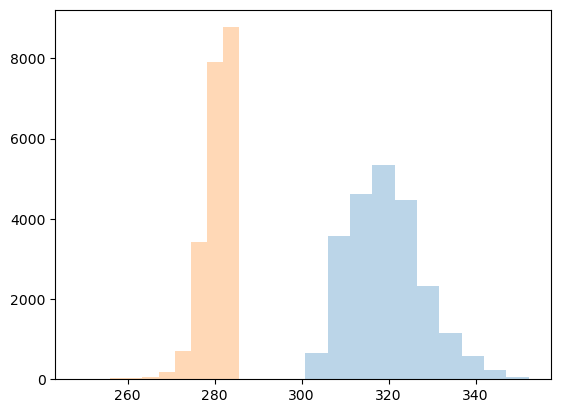

In [281]:
def compute_lapse_rate_accurate(RH, T, P_surf):
    """Compute RH-dependent lapse rate (Gamma in K/km) using a more physically accurate formula."""
    gamma_d = 9.8  # Dry adiabatic lapse rate (K/km)
    
    # Constants
    L_v = 2.5e6  # Latent heat of vaporization (J/kg)
    cp = 1005  # Specific heat of dry air (J/kg/K)
    epsilon = 0.622  # Ratio of molecular weights of water vapor to dry air
    
    # Saturation vapor pressure (Tetens formula)
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))  # in hPa
    e = RH * e_s  # Actual vapor pressure (hPa)
    
    # Mixing ratio
    w = epsilon * (e / (P_surf - e))  # kg/kg
    
    # Virtual temperature correction
    Tv = (T + 273.15) * (1 + 0.61 * w)
    
    # Moist adiabatic lapse rate (Deduced from Clausius-Clapeyron)
    gamma_m = gamma_d * (1 + (L_v * w) / (cp * Tv)) / (1 + (L_v**2 * w) / (cp * 287 * Tv**2))
    
    return gamma_m


def compute_equivalent_potential_temperature(T, RH, P_surf):
    """Compute equivalent potential temperature θ_e (K)."""
    L_v = 2.5e6  # Latent heat of vaporization (J/kg)
    cp = 1005    # Specific heat of dry air (J/kg/K)
    epsilon = 0.622  # Ratio of molecular weights of water vapor to dry air
    
    # Compute saturation vapor pressure (hPa) using Tetens' formula
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))
    e = RH * e_s  # Actual vapor pressure (hPa)
    
    # Mixing ratio (kg/kg)
    w = epsilon * (e / (P_surf - e))
    
    # Compute potential temperature θ
    theta = T * (1000 / P_surf) ** 0.286
    
    # Compute equivalent potential temperature θ_e
    theta_e = theta * np.exp((L_v * w) / (cp * T))
    
    return theta_e


def normalize_lapse_rate(gamma_m, T, RH, P_surf):
    """Normalize lapse rate using equivalent potential temperature."""
    theta_e = compute_equivalent_potential_temperature(T, RH, P_surf)
    
    # Scale gamma_m by the deviation from the reference θ_e
    gamma_m_norm = gamma_m * (theta_e / np.mean(theta_e))
    
    return gamma_m_norm


def adjust_temperature_and_elevation(T, RH, P_surf, z, z_ref):
    """Compute sea-level adjusted temperature and equivalent elevation."""
    gamma_rh = compute_lapse_rate_accurate(RH, T, P_surf)
    gamma_norm = normalize_lapse_rate(gamma_rh, T, RH, P_surf)
    
    # Adjust temperature to sea level
    T_sea_level = T + gamma_norm * ((z - z_ref) / 1000)  
    
    # Compute equivalent potential temperature
    theta_e = compute_equivalent_potential_temperature(T, RH, P_surf)
    
    # Reference equivalent potential temperature (use mean or a fixed value)
    theta_ref = 288.1 #compute_equivalent_potential_temperature(np.mean(T), RH, P_surf) # or a fixed reference like 288.15 K
    
    # Final temperature correction
    T_corrected = T_sea_level * (theta_e / theta_ref)**(0.1)
    
    # # Adjust elevation to match temperature correction
    z_eq = z + ((T - T_corrected) / gamma_norm) * 1000  
    
    return T_sea_level, T_corrected, theta_e


# Compute and display adjusted temperatures and potential temperatures
T_sea_level_0, T_adj_0, Theta_e_0 = adjust_temperature_and_elevation(T_2m_0, RH_0, elev_0, PS_0, z_ref=1000)
T_sea_level_7, T_adj_7, Theta_e_7 = adjust_temperature_and_elevation(T_2m_7, RH_7, elev_7, PS_7, z_ref=1000)


fig = plt.figure()
plt.scatter([x for x in T_2m_7], [y for y in elev_7], alpha=.1, label="cluster_7")
plt.scatter([x for x in T_2m_0], [y for y in elev_0], alpha=.1, label="cluster_0")
plt.legend()
plt.show()

fig = plt.figure()
plt.scatter([x for x in T_sea_level_7], [y for y in elev_7], alpha=.1, label="cluster_7")
plt.scatter([x for x in T_sea_level_0], [y for y in elev_0], alpha=.1, label="cluster_0")
plt.legend()
plt.show()

# fig = plt.figure()
# plt.scatter([x for x in T_sea_level_7], [y for y in z_eq_7], alpha=.1, label="cluster_7")
# plt.scatter([x for x in T_sea_level_0], [y for y in z_eq_0], alpha=.1, label="cluster_0")
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.scatter([x for x in T_adj_7], [y for y in elev_7], alpha=.1, label="cluster_7")
# plt.scatter([x for x in T_adj_0], [y for y in elev_0], alpha=.1, label="cluster_0")
# plt.legend()
# plt.show()

# fig = plt.figure()
# plt.scatter([x for x in T_adj_7], [y for y in Theta_e_7], alpha=.1, label="cluster_7")
# plt.scatter([x for x in T_adj_0], [y for y in Theta_e_0], alpha=.1, label="cluster_0")
# plt.legend()
# plt.show()

fig = plt.figure()
plt.hist(T_2m_7, alpha=.3)
plt.hist(T_2m_0, alpha=.3)
plt.show()

fig = plt.figure()
plt.hist(T_sea_level_7, alpha=.3)
plt.hist(T_sea_level_0, alpha=.3)
plt.show()


(array([ 666., 3938., 4168., 4046., 4312., 3154., 1674.,  713.,  253.,
          56.]),
 array([ 3.91041851,  4.70674419,  5.50307035,  6.29939604,  7.0957222 ,
         7.89204788,  8.68837357,  9.48469925, 10.28102493, 11.07735062,
        11.87367725]),
 <BarContainer object of 10 artists>)

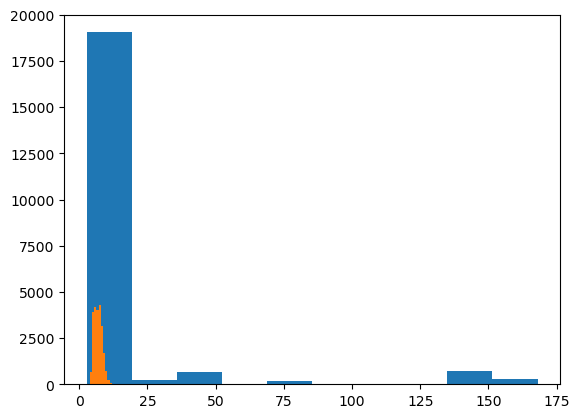